<a href="https://colab.research.google.com/github/MahmoodAbdali79/Telecom-Churn/blob/main/Telecom_EDA_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import scipy.stats as st
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor



import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
# inspire https://github.com/ShivaliPatel/Data-science-projects/tree/master/Telco_customer_churn

In [ ]:
df = pd.read_csv('drive/MyDrive/Data/Telco-Customer-Churn.csv')

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Manipulation and Handeling Missing Value
As we can see number of missing value is little. So difference betwee data with/whout missin value is not very much. And because mssing value is MCAR, I consider this method to experiment.
- Imputation
  - Mean/Mode/Median imputation  
  -  Add vaiable to denote NA  
- Listwise Deletion  

In [ ]:
def preprocess(df):
  # drop Customer ID
  df.drop(['customerID'], axis=1, inplace=True)

  # turn into numerical and fill NA value
  df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
  df['TotalCharges_missing'] = df['TotalCharges'].isnull().astype(int)

  imputation_value = df['TotalCharges'].mode()[0] # for considering mode
  # imputation_value = df['TotalCharges'].mean() # for considering mean
  # imputation_value = df['TotalCharges'].median() # for considering median
  df['TotalCharges'] = df['TotalCharges'].fillna(imputation_value)

  # drop rows with tenure of 0
  df.drop(labels=df[df['tenure']==0].index, axis=0, inplace=True)

  # map SeniorCitizen
  df['SeniorCitizen'] = df['SeniorCitizen'].map({0:"No", 1:"Yes"})

  for col in df.columns:
    if len(df[col].unique()) < 2:
      df.drop(col, axis=1, inplace=True)
  return df

In [ ]:
df = preprocess(df)

# EDA
## First sence from contious data
- more than 75% Senior citizen are did not churn  
- tenure sounds like is normal distribution  
- monthly distribution may have skwed  
- totoal distribution may have skwed  

## Visualization

### Target Distribution

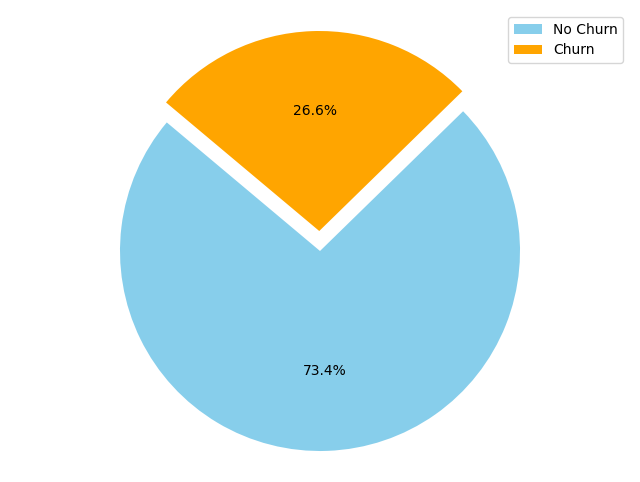

In [ ]:
plt.figure(figsize=(8, 6))
colors = ['skyblue', 'orange']
sizes = df['Churn'].value_counts(normalize=True)
explode = (0, 0.1)  # explode the second slice (Churned)
plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', startangle=140)
plt.legend(['No Churn', 'Churn'], loc='upper right')
plt.axis('equal')
plt.show()

as we can see. the target value is not balanced and this can effect on out machin learning modle.

### Explore Categorical Variable

In [ ]:
var = "gender"
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [ ]:
var = 'Partner'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [ ]:
var = 'Dependents'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [ ]:
var = 'PhoneService'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [ ]:
var = 'MultipleLines'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [ ]:
var = 'InternetService'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [ ]:
var = 'OnlineSecurity'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [ ]:
var = 'OnlineBackup'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [ ]:
var = 'DeviceProtection'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [ ]:
var = 'TechSupport'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [ ]:
var = 'StreamingTV'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [ ]:
var = 'StreamingMovies'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [ ]:
var = 'Contract'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [ ]:
var = 'PaymentMethod'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [ ]:
var = 'SeniorCitizen'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

### Explore Numerical Variable and Identify Outlier

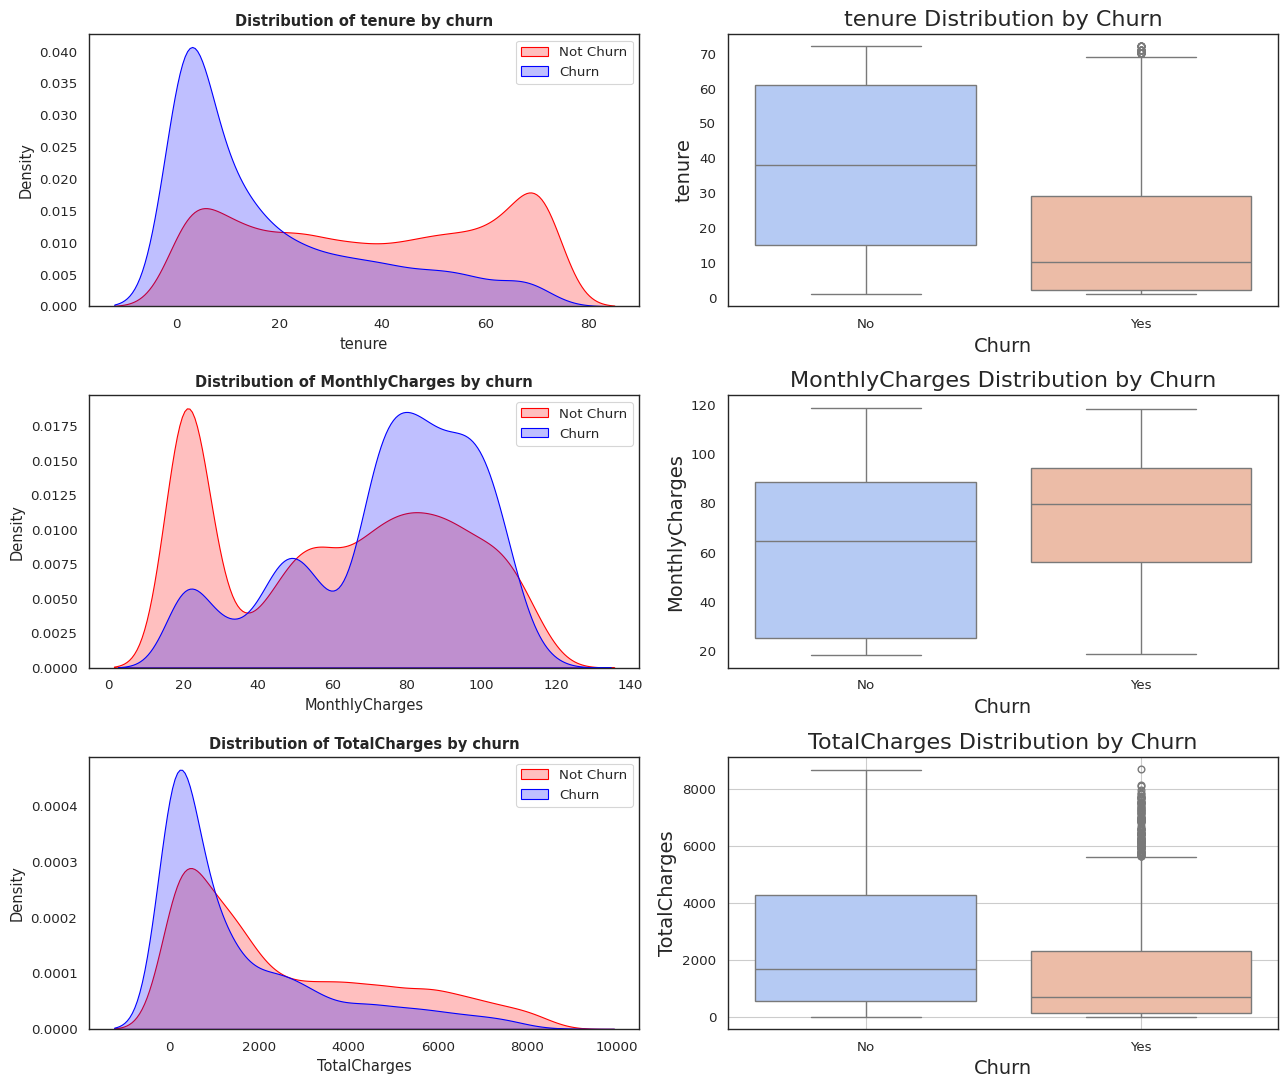

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(13, 11))
numerical_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

for ax, col in zip(axes, numerical_vars):
  sns.kdeplot(df[col][(df["Churn"] == 'No')], color="Red", fill=True, ax=ax[0])
  sns.kdeplot(df[col][(df["Churn"] == 'Yes')], color="Blue", fill= True, ax=ax[0])
  ax[0].legend(["Not Churn","Churn"],loc='upper right')
  ax[0].set_title(f'Distribution of {col} by churn', fontweight="bold")

  sns.boxplot(x='Churn', y=col, data=df, palette='coolwarm', hue='Churn', ax=ax[1])
  ax[1].set_title(f'{col} Distribution by Churn', fontsize=16)
  ax[1].set_xlabel('Churn', fontsize=14)
  ax[1].set_ylabel(col, fontsize=14)
  plt.grid(True)


fig.tight_layout()
plt.show()

#### Cross Tabulation and Chi-square Test of Independence  **
for showing if there is any relationship between two variable cross tablulation and chi-square test have used

**Hypothesis**:
- H0: There is a significant relationship between two variable
- H1: There is no relationship between two variable
- Cl: 95%

**Result**: There is no relationship between each two category variable. Detail shown in the below.

Chi-square statistic: 0.48
P-value: 0.4866


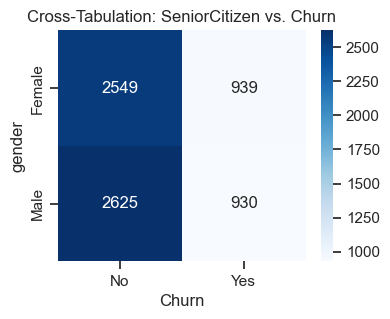

In [ ]:
Cat = 'gender'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 158.73
P-value: 0.0000


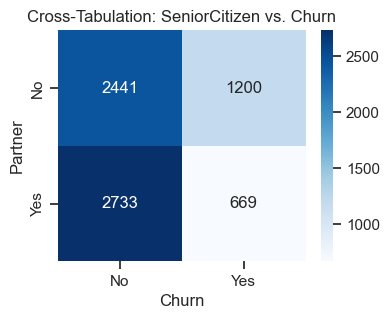

In [ ]:
Cat = 'Partner'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 189.13
P-value: 0.0000


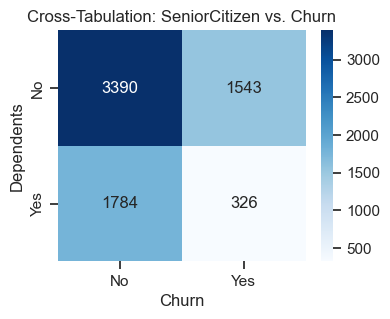

In [ ]:
Cat = 'Dependents'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 0.92
P-value: 0.3388


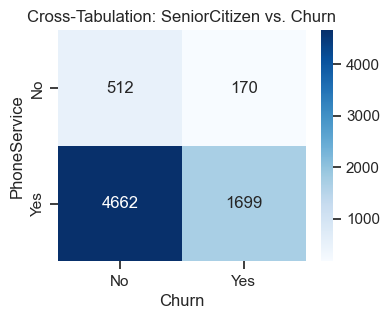

In [ ]:
Cat = 'PhoneService'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 11.33
P-value: 0.0035


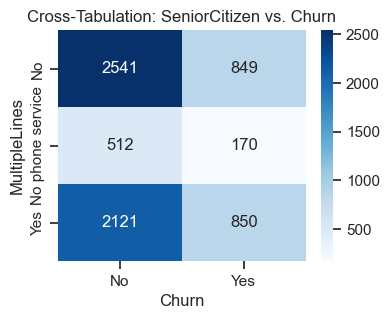

In [ ]:
Cat = 'MultipleLines'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 732.31
P-value: 0.0000


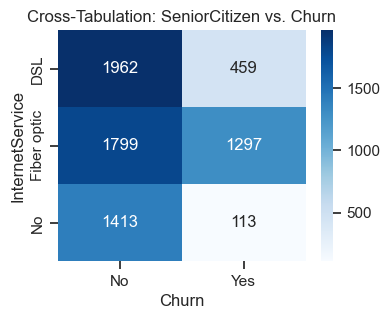

In [ ]:
Cat = 'InternetService'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 850.00
P-value: 0.0000


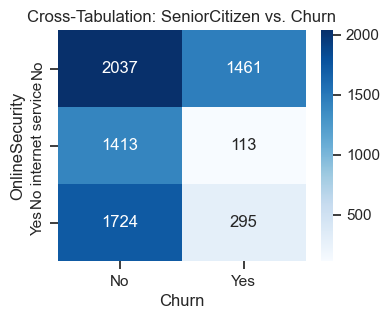

In [ ]:
Cat = 'OnlineSecurity'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 601.81
P-value: 0.0000


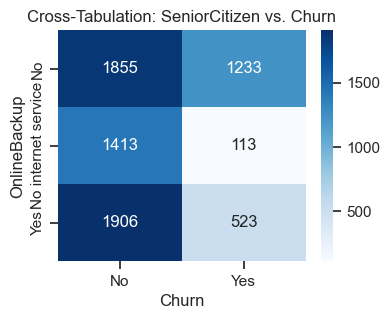

In [ ]:
Cat = 'OnlineBackup'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 558.42
P-value: 0.0000


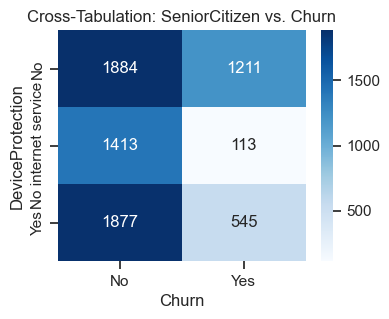

In [ ]:
Cat = 'DeviceProtection'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 828.20
P-value: 0.0000


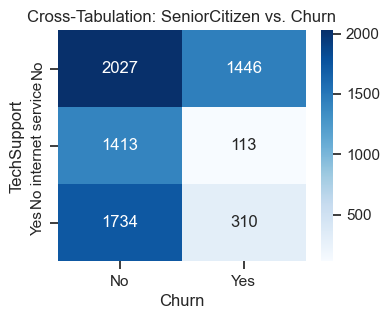

In [ ]:
Cat = 'TechSupport'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 374.20
P-value: 0.0000


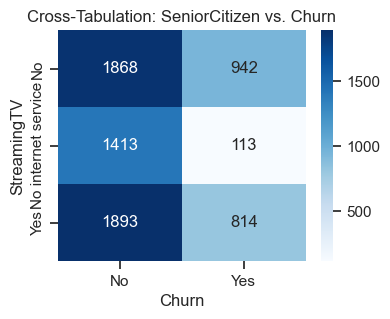

In [ ]:
Cat = 'StreamingTV'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 375.66
P-value: 0.0000


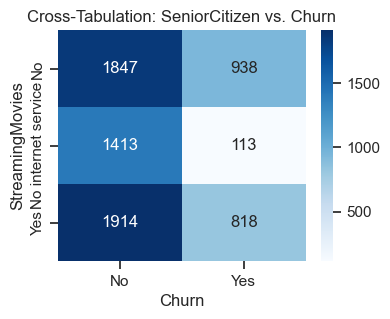

In [ ]:
Cat = 'StreamingMovies'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 1184.60
P-value: 0.0000


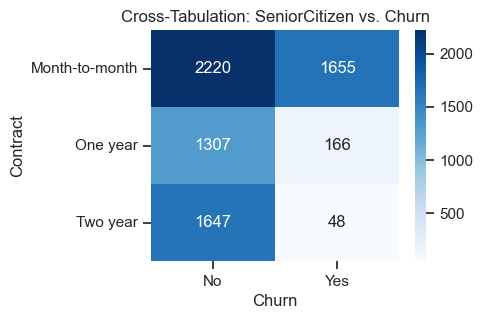

In [ ]:
Cat = 'Contract'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 258.28
P-value: 0.0000


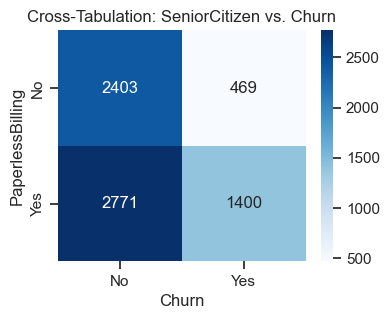

In [ ]:
Cat = 'PaperlessBilling'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 648.14
P-value: 0.0000


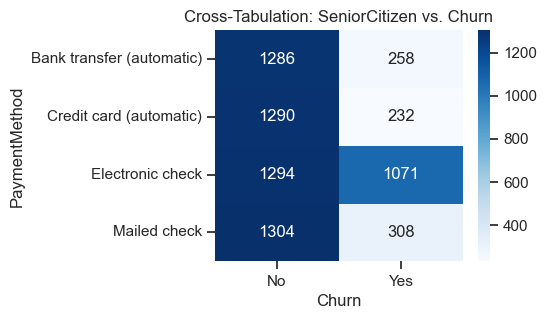

In [ ]:
Cat = 'PaymentMethod'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

Chi-square statistic: 159.43
P-value: 0.0000


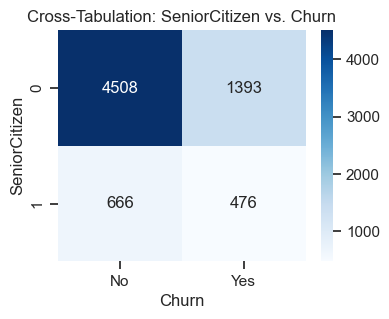

In [ ]:
Cat = 'SeniorCitizen'
cross_tab = pd.crosstab(df[Cat], df['Churn'])
chi2, p, _, _ = st.chi2_contingency(cross_tab)

# Print the results
print("Chi-square statistic:", f'{chi2:.2f}')
print("P-value:", f'{p:.4f}')

# Create a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Churn')
plt.ylabel(Cat)
plt.title('Cross-Tabulation: SeniorCitizen vs. Churn')
plt.show()

#### Multivariate Analysis  **

In [ ]:
from itertools import combinations

cat_var = ['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService',
            'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling',
            'PaymentMethod','SeniorCitizen']

pair_cat = list(combinations(cat_var, 2))

In [ ]:
mul_var = []

for c in pair_cat:
    A = df[['Churn', c[0], c[1]]].value_counts(normalize=True).sort_values().tail()
    for v, i in zip(A.values, A.index):
        if i[0]=='Yes':
            mul_var.append([(c[0], c[1]), i, v])

mul_var.sort(key= lambda x : x[2], reverse=True)
mul_var = mul_var[:10]

for v in mul_var:
    print(f'Churn: {v[1][0]} {v[0][0]:>16}: {v[1][1]:9} {v[0][1]:>17}: {v[1][2]:<18} {"=>"} {v[2]:.2f}')

Churn: Yes     PhoneService: Yes                Contract: Month-to-month     => 0.21
Churn: Yes       Dependents: No             PhoneService: Yes                => 0.20
Churn: Yes       Dependents: No                 Contract: Month-to-month     => 0.20
Churn: Yes      TechSupport: No                 Contract: Month-to-month     => 0.19
Churn: Yes   OnlineSecurity: No                 Contract: Month-to-month     => 0.19
Churn: Yes     PhoneService: Yes          OnlineSecurity: No                 => 0.19
Churn: Yes     PhoneService: Yes             TechSupport: No                 => 0.19
Churn: Yes     PhoneService: Yes         InternetService: Fiber optic        => 0.18
Churn: Yes     PhoneService: Yes        PaperlessBilling: Yes                => 0.18
Churn: Yes     PhoneService: Yes           SeniorCitizen: 0                  => 0.18


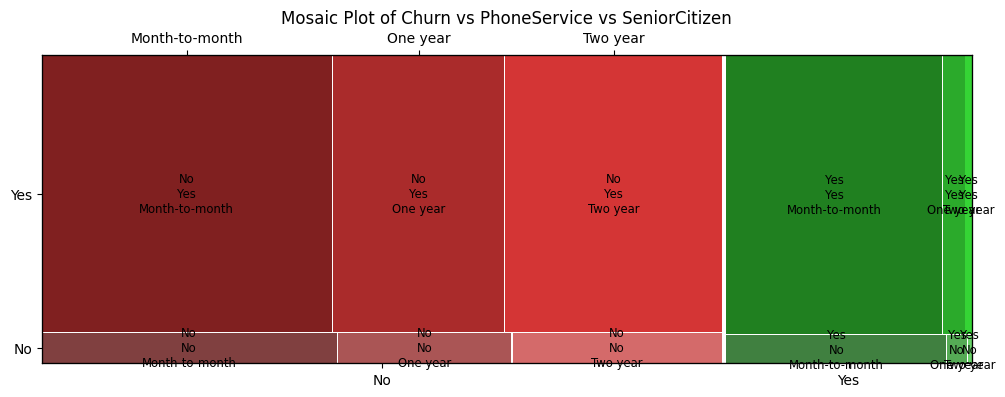

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

mosaic(df, ['Churn', 'PhoneService', 'Contract'], title='Mosaic Plot of Churn vs PhoneService vs SeniorCitizen', ax=ax)
plt.show()

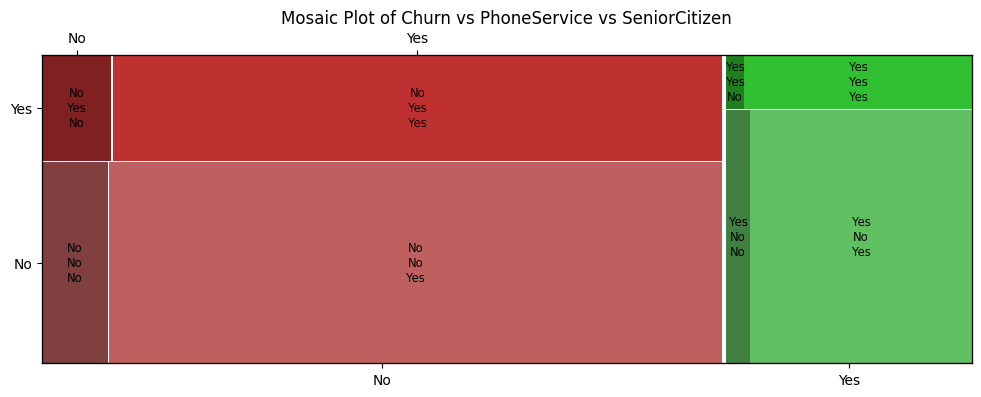

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

mosaic(df, ['Churn', 'Dependents', 'PhoneService'], title='Mosaic Plot of Churn vs PhoneService vs SeniorCitizen', ax=ax)
plt.show()

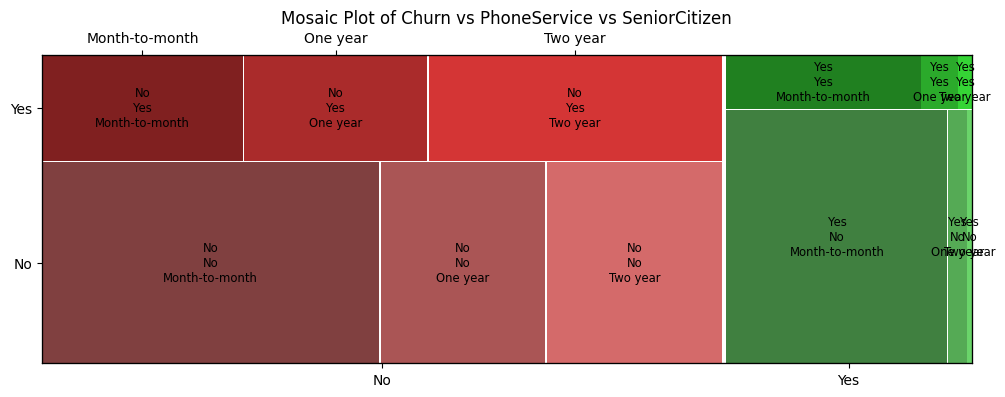

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

mosaic(df, ['Churn', 'Dependents', 'Contract'], title='Mosaic Plot of Churn vs PhoneService vs SeniorCitizen', ax=ax)
plt.show()

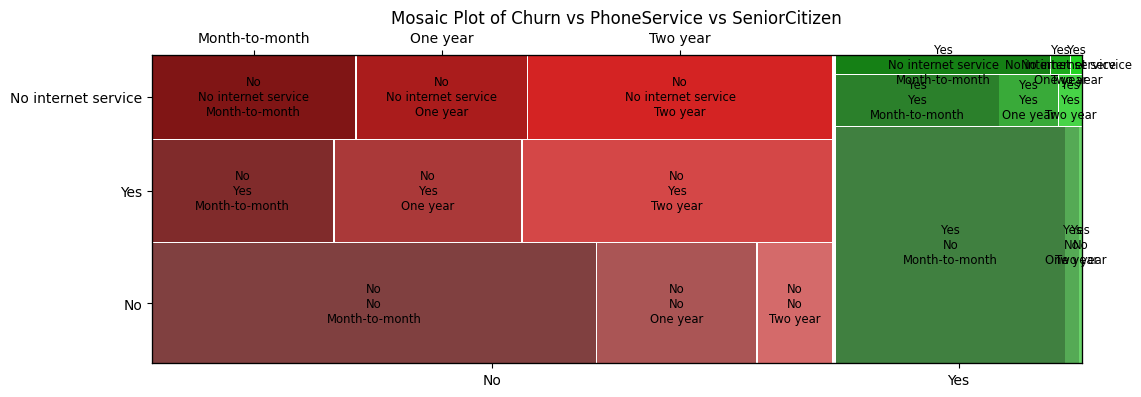

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

mosaic(df, ['Churn', 'TechSupport', 'Contract'], title='Mosaic Plot of Churn vs PhoneService vs SeniorCitizen', ax=ax)
plt.show()

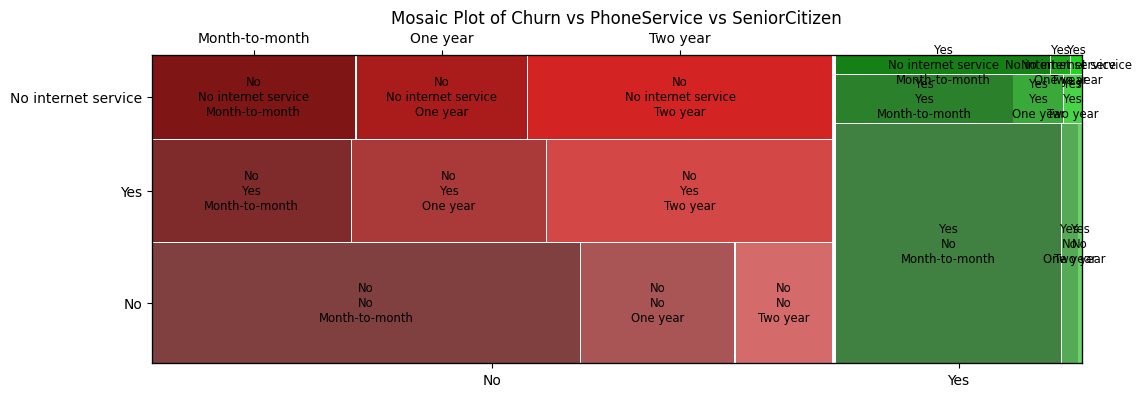

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

mosaic(df, ['Churn', 'OnlineSecurity', 'Contract'], title='Mosaic Plot of Churn vs PhoneService vs SeniorCitizen', ax=ax)
plt.show()

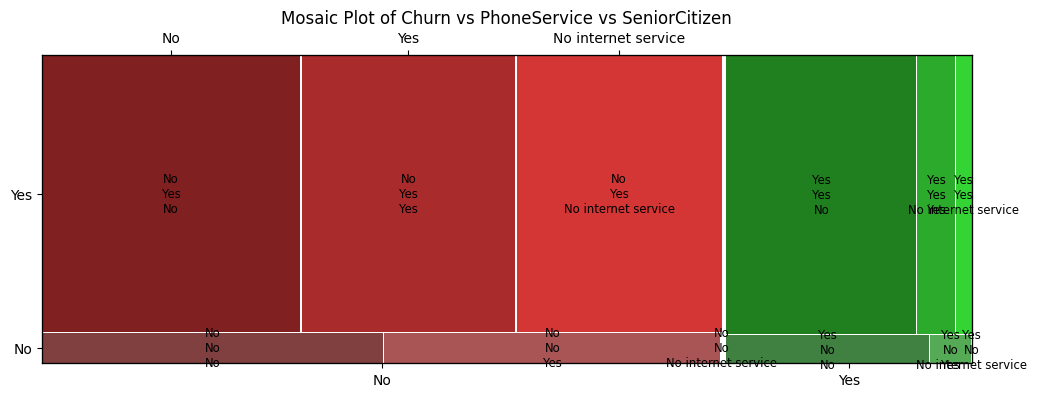

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

mosaic(df, ['Churn', 'PhoneService', 'OnlineSecurity'], title='Mosaic Plot of Churn vs PhoneService vs SeniorCitizen', ax=ax)
plt.show()

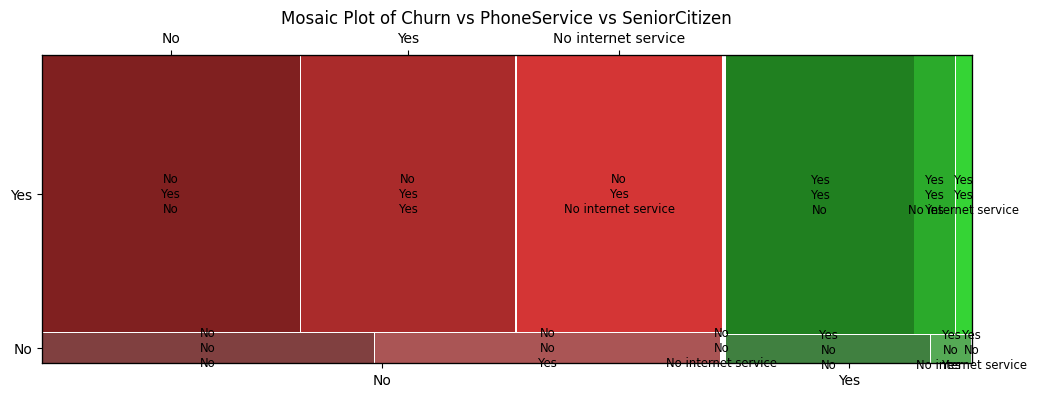

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

mosaic(df, ['Churn', 'PhoneService', 'TechSupport'], title='Mosaic Plot of Churn vs PhoneService vs SeniorCitizen', ax=ax)
plt.show()

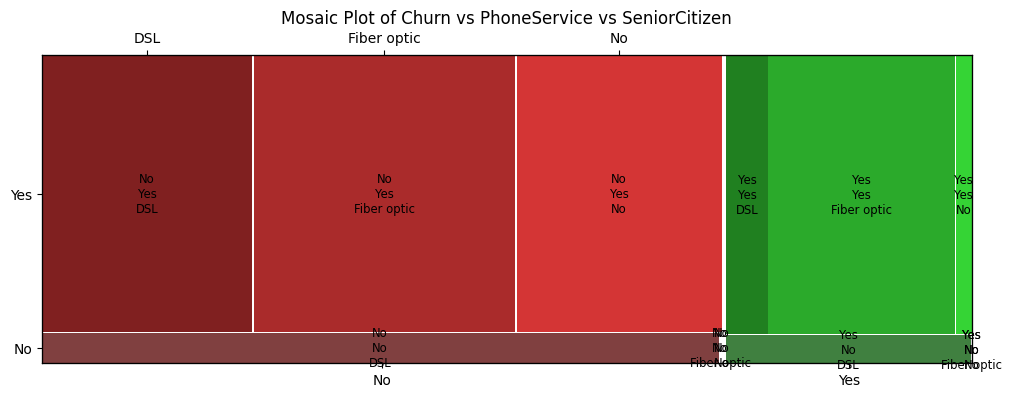

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

mosaic(df, ['Churn', 'PhoneService', 'InternetService'], title='Mosaic Plot of Churn vs PhoneService vs SeniorCitizen', ax=ax)
plt.show()

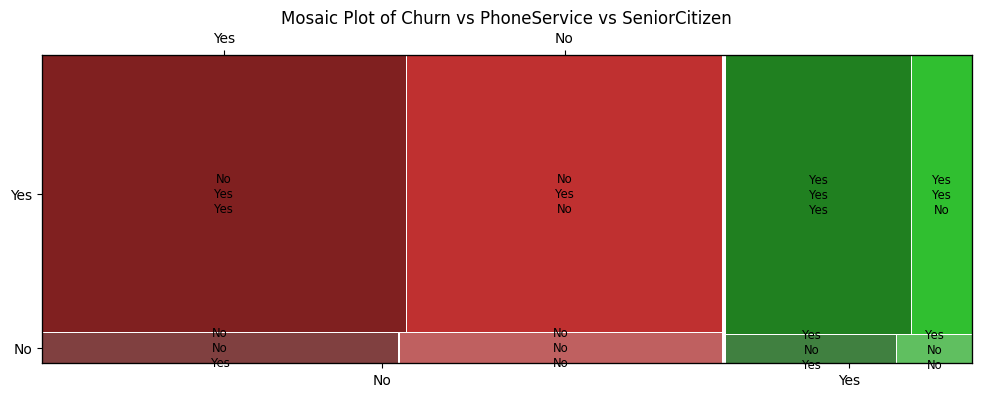

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

mosaic(df, ['Churn', 'PhoneService', 'PaperlessBilling'], title='Mosaic Plot of Churn vs PhoneService vs SeniorCitizen', ax=ax)
plt.show()

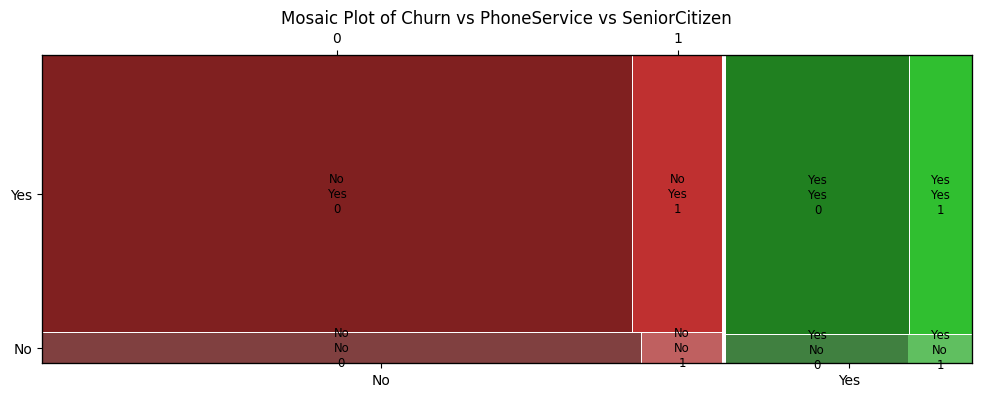

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

mosaic(df, ['Churn', 'PhoneService', 'SeniorCitizen'], title='Mosaic Plot of Churn vs PhoneService vs SeniorCitizen', ax=ax)
plt.show()

#### Feature Importance
This could be done after feature engineering and generate new feature
but for running association rules mining we need more resource wich currently does not available. So best way for handle this iss finding most important features by aprouches like tree-based algorithms or premutation importance to rank the importance of categorical features.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

Cat_col = ['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
           'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod', 'SeniorCitizen', 'Churn']


label_encoder = LabelEncoder()
df_encoded = df.copy()
df_encoded.drop('customerID', axis=1, inplace=True)

for c in Cat_col:
  df_encoded[c] = label_encoder.fit_transform(df[c])



X = df_encoded[Cat_col[:-1]]
Y = df_encoded['Churn']


rf = RandomForestClassifier()
rf.fit(X, Y)

RandomForestClassifier()

In [ ]:
feature_importance = rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature':X.columns, 'Importance':feature_importance})

feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

In [ ]:
feature_importance_df['Feature']

12            Contract
14       PaymentMethod
6       OnlineSecurity
9          TechSupport
0               gender
4        MultipleLines
5      InternetService
7         OnlineBackup
8     DeviceProtection
1              Partner
10         StreamingTV
11     StreamingMovies
13    PaperlessBilling
15       SeniorCitizen
2           Dependents
3         PhoneService
Name: Feature, dtype: object

### Hypothetis for compairing mean and median.

#### By orginal data

In [ ]:
# normal test
for var in numerical_vars:
  Churn = df[df['Churn']=='Yes'][var]
  Not_Churn = df[df['Churn']=='No'][var]
  print(f'P-value of {var} - churn : {st.normaltest(Churn)[1]:.3f}')
  print(f'P-value of {var} - Not churn : {st.normaltest(Not_Churn)[1]:.3f}')

P-value of tenure - churn : 0.000
P-value of tenure - Not churn : 0.000
P-value of MonthlyCharges - churn : 0.000
P-value of MonthlyCharges - Not churn : 0.000
P-value of TotalCharges - churn : 0.000
P-value of TotalCharges - Not churn : 0.000


**H0**: Mean of (tenure, MonthlyCharges, TotalCharges) for user two group of people who churn/not churn is equal

**H1**: Mean of (tenure, MonthlyCharges, TotalCharges) for user two group of people who churn/not churn is not equal

**CL**: 0.95

In [ ]:
Churn = df[df['Churn']=='Yes']
Not_Churn = df[df['Churn']=='No']

for var in numerical_vars:
  statistics, p_value = st.mannwhitneyu(Churn[var], Not_Churn[var], alternative ='less')
  print(f'Mann-Whitney U-test for {var}:')
  print(f'  Test Statistics: {statistics:.3f}')
  print(f'  P-value: {p_value:.5f}')

  if p_value <0.05:
    print(f'  There is significant difference in {var} between churned and not churned customer')
  else:
    print(f'  There is not significant difference in {var} between churned and not churned customer')
  print()

Mann-Whitney U-test for tenure:
  Test Statistics: 2494979.000
  P-value: 0.00000
  There is significant difference in tenure between churned and not churned customer

Mann-Whitney U-test for MonthlyCharges:
  Test Statistics: 5986148.500
  P-value: 1.00000
  There is not significant difference in MonthlyCharges between churned and not churned customer

Mann-Whitney U-test for TotalCharges:
  Test Statistics: 3360665.000
  P-value: 0.00000
  There is significant difference in TotalCharges between churned and not churned customer



#### By normall sample data

In [ ]:
def TurnIntolist(x):
  if isinstance(x, list):
    pass
  else:
    x = [x]
  return x

def significant_test(numerical_vars, df):
  numerical_vars = TurnIntolist(numerical_vars)
  # Define the sample size and number of samples
  sample_size = 100  # Adjust as needed
  num_samples = 1000  # Adjust as needed
  np.random.seed(0)
  NoT_churn_sample_data = pd.DataFrame(columns=numerical_vars)
  Churn_sample_data = pd.DataFrame(columns=numerical_vars)

  for var in numerical_vars:
    # Generate the non-normally distributed population data
    NoT_churn_data = df[df['Churn']=='No'][var]
    Churn_data = df[df['Churn']=='Yes'][var]

    # Create an array to store the sample means
    NoT_churns_ample_means = np.zeros(num_samples)
    Churn_sample_means = np.zeros(num_samples)

    # Generate samples and calculate sample means
    for i in range(num_samples):
        NoT_churn_sample = np.random.choice(NoT_churn_data, size=sample_size, replace=True)
        NoT_churns_ample_means[i] = np.mean(NoT_churn_sample)

        churn_sample = np.random.choice(Churn_data, size=sample_size, replace=True)
        Churn_sample_means[i] = np.mean(churn_sample)

    NoT_churn_sample_data[var] = NoT_churns_ample_means
    Churn_sample_data[var] = Churn_sample_means

    # Perform a normality test on the sample means
    NoT_churn_normality_test_P = st.normaltest(NoT_churn_sample_data[var])[1]
    churn_normality_test_P = st.normaltest(Churn_sample_data[var])[1]
    print(f'Normality Test Result for {var}:')
    print(f'Not Churn Normality P-value = {NoT_churn_normality_test_P:.3f}')
    print(f'Churn Normality P-value = {churn_normality_test_P:.3f}')

    if NoT_churn_normality_test_P > 0.05 and churn_normality_test_P > 0.005:

      t_statistic, p_value = st.ttest_ind(NoT_churn_sample_data[var], Churn_sample_data[var])

      # Print the test result
      print(f'Two-sample t-test for {var}')
      print("T-statistic:", t_statistic)
      print("P-value:", p_value)

      # Check the significance level (usually 0.05)
      alpha = 0.05
      if p_value < alpha:
          print(f"The {var} are significantly different between churn / not churn")
      else:
          print(f"There is no significant difference in {var} between churn / not churn.")
    else:
      print('sample datas are not normal, rerun the function')
    print('-----------------------------')


In [ ]:
significant_test(['tenure', 'MonthlyCharges', 'TotalCharges'], df)

Normality Test Result for tenure:
Not Churn Normality P-value = 0.830
Churn Normality P-value = 0.044
Two-sample t-test for tenure
T-statistic: 203.87906466696862
P-value: 0.0
The tenure are significantly different between churn / not churn
-----------------------------
Normality Test Result for MonthlyCharges:
Not Churn Normality P-value = 0.389
Churn Normality P-value = 0.240
Two-sample t-test for MonthlyCharges
T-statistic: -104.5109707962799
P-value: 0.0
The MonthlyCharges are significantly different between churn / not churn
-----------------------------
Normality Test Result for TotalCharges:
Not Churn Normality P-value = 0.334
Churn Normality P-value = 0.364
Two-sample t-test for TotalCharges
T-statistic: 108.12018316242401
P-value: 0.0
The TotalCharges are significantly different between churn / not churn
-----------------------------


## Correlation Analysis

In [ ]:
#Create a label encoder object
le = LabelEncoder()
# Label Encoding will be used for columns with 2 or less unique
LDF = df.copy()
lablaed = []

for col in df.columns:
    if df[col].dtype == 'object':
      le.fit(df[col])
      LDF[col] = le.transform(df[col])
      lablaed.append(col)

# filtter same correlation
correlation = LDF.corrwith(LDF.Churn)
correlation = correlation[correlation!=1]

# plot correlation
fig = px.bar(correlation, x=correlation.index, y = correlation.values)
fig.show()

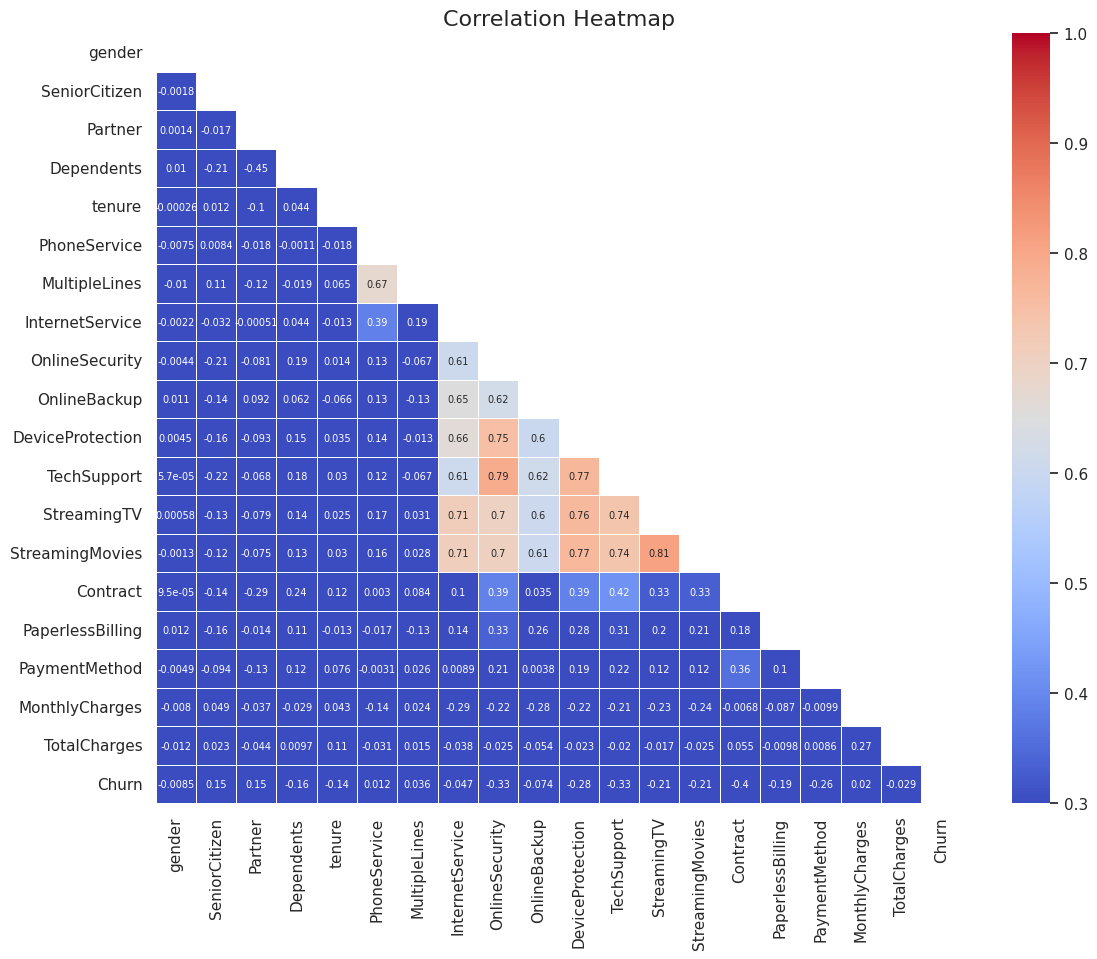

In [ ]:
sns.set(style="white")
plt.figure(figsize=(13, 10))

# Calculate correlation matrix
corr = LDF.apply(lambda x: pd.factorize(x)[0]).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap with adjusted font size
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns,
                 annot=True, annot_kws={"size": 7}, linewidths=.5, cmap='coolwarm', vmin=0.3, vmax=1)

# Adjust the title font size
ax.set_title('Correlation Heatmap', fontsize=16)

plt.show()

In [ ]:
# Assuming 'X' is your DataFrame containing the predictor variables
# Add a constant term to the predictor variables (required for statsmodels)

vif = pd.DataFrame()
vif["variables"] = LDF.columns
vif["VIF"] = [variance_inflation_factor(LDF.values, i) for i in range(LDF.shape[1])]

In [ ]:
vif

,variables,VIF
0,gender,1.954856
1,SeniorCitizen,1.373354
2,Partner,2.819317
3,Dependents,1.957986
4,tenure,15.086501
5,PhoneService,15.198554
6,MultipleLines,2.761146
7,InternetService,4.379748
8,OnlineSecurity,2.257841
9,OnlineBackup,2.459222


# Save data

In [ ]:
df.to_csv('drive/MyDrive/Data/Telco-Customer-Churn_V1.csv')

## Summerize Finding

Well, Until here we dinfout there is no simple relationship between features.

And I conduct a hypothesis test to see is there significant difference between churn user and not churn user in tenure,MonthlyCharges and TotalCharges:
- There is significant difference in tenure between churned and not churned customer

- There is not significant difference in MonthlyCharges between churned and not churned customer

- There is significant difference in TotalCharges between churned and not churned customer

# Feature Engineering

In [ ]:
object_col = df.select_dtypes('object').columns.to_list()[1:]
object_col.pop(-4)

'Contract'

In [ ]:
for c in object_col:
  print(c, df[c].unique().tolist())

gender ['Female', 'Male']
Partner ['Yes', 'No']
Dependents ['No', 'Yes']
PhoneService ['No', 'Yes']
MultipleLines ['No phone service', 'No', 'Yes']
InternetService ['DSL', 'Fiber optic', 'No']
OnlineSecurity ['No', 'Yes', 'No internet service']
OnlineBackup ['Yes', 'No', 'No internet service']
DeviceProtection ['No', 'Yes', 'No internet service']
TechSupport ['No', 'Yes', 'No internet service']
StreamingTV ['No', 'Yes', 'No internet service']
StreamingMovies ['No', 'Yes', 'No internet service']
PaperlessBilling ['Yes', 'No']
PaymentMethod ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
Churn ['No', 'Yes']


In [ ]:
def Label_Encoder(df):
  ordinal_mapping = {'low': 0, 'medium': 1, 'high': 2}
  df['Contract_Encoded'] = df['Contract'].map(ordinal_mapping)
  print(f'contract encoded')

  label_encoder = LabelEncoder()
  for c in object_col:
    df[c] = label_encoder.fit_transform(df[c])
    print(f'{c} encoded')

    return df

In [ ]:
A = Label_Encoder(df)

contract encoded
gender encoded


In [ ]:
# for c in object_col:
#   print(c, df[c].unique().tolist())


A

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_missing,Contract_Encoded
0,7590-VHVEG,0,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,NaN
1,5575-GNVDE,1,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.50,No,0,NaN
2,3668-QPYBK,1,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0,NaN
3,7795-CFOCW,1,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,NaN
4,9237-HQITU,0,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0,NaN
7039,2234-XADUH,0,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,0,NaN
7040,4801-JZAZL,0,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,NaN
7041,8361-LTMKD,1,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,0,NaN


# Model Selection and Evaluation

# Hyperparameter Tuning

# Model Intepretion

# Documentation and Reporting

## Feature Importance Analysis

## Logistic Regression

## Decision Trees and Random Forests